# A2Perf System and Reliability Metrics


In [44]:
!pip install tensorboard sns tbparse matplotlib pandas scipy


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [45]:
import collections
import glob
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import tensorboard as tb
import tensorflow as tf
from packaging import version
from scipy import stats

In [46]:
major_ver, minor_ver, _ = version.parse(tb.__version__).release
assert major_ver >= 2 and minor_ver >= 3, \
  "This notebook requires TensorBoard 2.3 or later."
print("TensorBoard version: ", tb.__version__)

TensorBoard version:  2.14.1


In [47]:
base_dir = '/home/ikechukwuu/workspace/gcs/a2perf/'
debug = False

algo_to_exp_dict = dict(
    ppo='0014',
    ddpg='0002'
)
domain = 'quadruped_locomotion'
task = 'dog_pace'

algo_to_seeds = dict(
    ppo=[
        37,
        14,
        82,
        # 23,
        65,
        98
    ]
    ,
    ddpg=[
        # 37,
        14,
        82,
        23,
        65,
        98
    ]
)

all_seeds_to_process = []
for algo, seeds in algo_to_seeds.items():
  all_seeds_to_process.extend(seeds)

## Reliability Metrics

In [48]:
log_dirs = []
experiment_base_dir = os.path.join(base_dir, domain, 'debug' if debug else '',
                                   task)

# reduce all seeds over all algorithms to a single list

for algo in algo_to_exp_dict.keys():
  experiment_path = os.path.join(experiment_base_dir, algo,
                                 algo_to_exp_dict[algo],
                                 f'**/tensorboard/{algo.upper()}_0_1/*events*')
  print(f'Experiment Path: {experiment_path}')

  log_dirs.extend(glob.glob(experiment_path, recursive=True))

log_dirs = [log_dir for log_dir in log_dirs if
            any([f'seed_{seed}' in log_dir for seed in all_seeds_to_process])]
log_dirs

Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0014/**/tensorboard/PPO_0_1/*events*
Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/0002/**/tensorboard/DDPG_0_1/*events*


['/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0014/quadruped_locomotion_int_save_freq_1000000_parallel_cores_170_seed_65_total_env_steps_200000000/tensorboard/PPO_0_1/events.out.tfevents.1699525270.locomotion-0',
 '/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0014/quadruped_locomotion_int_save_freq_1000000_parallel_cores_170_seed_14_total_env_steps_200000000/tensorboard/PPO_0_1/events.out.tfevents.1699496920.locomotion-1',
 '/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0014/quadruped_locomotion_int_save_freq_1000000_parallel_cores_170_seed_37_total_env_steps_200000000/tensorboard/PPO_0_1/events.out.tfevents.1699496880.locomotion-0',
 '/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0014/quadruped_locomotion_int_save_freq_1000000_parallel_cores_170_seed_23_total_env_steps_200000000/tensorboard/PPO_0_1/events.out.tfevents.1699526203.locomotion-1',
 '/home/ikechukwuu/workspace/gcs/a2p

In [49]:
print(len(log_dirs))

12


### Pack Data into DataFrame

In [50]:
def load_tb_data(event_file):
  iterations_data = dict()
  ep_rew_data = dict()
  timestamp_data = dict()

  for event in tf.compat.v1.train.summary_iterator(event_file):

    # get the timestamp of the evnet
    timestamp = event.wall_time

    # Convert the timestamp to a datetime object
    timestamp = pd.to_datetime(timestamp, unit='s')
    timestamp_data[event.step] = timestamp

    for value in event.summary.value:
      # Check for episode_reward in the event
      if value.tag == 'episode_reward':
        if event.step in ep_rew_data:
          raise ValueError(
              f'Found duplicate episode_reward data for step: {event.step}')
        ep_rew_data[event.step] = value.simple_value

      # Check for iterations in the event
      if value.tag == 'iterations':
        if event.step in iterations_data:
          raise ValueError(
              f'Found duplicate iterations data for step: {event.step}')
        iterations_data[event.step] = value.simple_value

  df = pd.DataFrame.from_dict(iterations_data, orient='index',
                              columns=['iterations'])
  df['episode_reward'] = df['iterations'].map(ep_rew_data)
  df['timestamp'] = df['iterations'].map(timestamp_data)
  df = df.reset_index()
  df = df.rename(columns={'index': 'step'})
  df = df.drop(columns=['iterations'])
  df['step'] = df['step'].astype(np.int32)
  return df



In [51]:
all_df = pd.DataFrame()
for log_dir in log_dirs:
  log_base_dir = os.path.dirname(log_dir)
  exp_split = log_dir.split('/')

  exp_name = exp_split[-4]
  exp_name_split = exp_name.split('_')

  seed = int(exp_name_split[-5])
  experiment = exp_split[-5]
  algo = exp_split[-6]
  if seed not in algo_to_seeds[algo]:
    continue

  print(f'Processing Experiment: {experiment}, Seed: {seed}, Algo: {algo}')

  if os.path.exists(os.path.join(log_base_dir, 'data.csv')):
    print(f'\tSkipping {log_dir} since data.csv already exists')
    data = pd.read_csv(os.path.join(log_base_dir, 'data.csv'))
  else:
    data = load_tb_data(log_dir)
    data['seed'] = seed
    data['experiment'] = experiment
    data['algo'] = algo
    print(f'\tSaving data.csv to {log_base_dir}')
    data.to_csv(os.path.join(log_base_dir, 'data.csv'))

  print(f'\tFinished processing {log_dir}')
  print(f'\tNumber of rows: {len(data)}')

  # Print out the last global step value
  print(f'\tLast global step value: {data["step"].iloc[-1]}')
  all_df = pd.concat([all_df, data])




Processing Experiment: 0014, Seed: 65, Algo: ppo
	Skipping /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0014/quadruped_locomotion_int_save_freq_1000000_parallel_cores_170_seed_65_total_env_steps_200000000/tensorboard/PPO_0_1/events.out.tfevents.1699525270.locomotion-0 since data.csv already exists
	Finished processing /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0014/quadruped_locomotion_int_save_freq_1000000_parallel_cores_170_seed_65_total_env_steps_200000000/tensorboard/PPO_0_1/events.out.tfevents.1699525270.locomotion-0
	Number of rows: 47059
	Last global step value: 47058
Processing Experiment: 0014, Seed: 14, Algo: ppo
	Skipping /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0014/quadruped_locomotion_int_save_freq_1000000_parallel_cores_170_seed_14_total_env_steps_200000000/tensorboard/PPO_0_1/events.out.tfevents.1699496920.locomotion-1 since data.csv already exists
	Finished processing /home/ikechukwu

In [52]:
for algo in algo_to_exp_dict.keys():
  algo_df = all_df[all_df['algo'] == algo]
  print(f'Algo: {algo}, Number of rows: {len(algo_df)}')

  # also get number of seeds
  print(f'Number of seeds: {len(algo_df["seed"].unique())}')


Algo: ppo, Number of rows: 235295
Number of seeds: 5
Algo: ddpg, Number of rows: 233920
Number of seeds: 5


In [53]:
for algo in algo_to_exp_dict.keys():
  df = all_df[all_df['algo'] == algo]
  print(f'Algo: {algo}')
  for seed, group in df.groupby('seed'):
    print(f'\tSeed: {seed}')
    diff = group['step'].diff()
    print(f'\t\tMin diff: {diff.min()}')
    print(f'\t\tMax diff: {diff.max()}')
    print(f'\t\tMedian diff: {diff.median()}')
    print(f'\t\tMean diff: {diff.mean()}')

Algo: ppo
	Seed: 14
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
	Seed: 37
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
	Seed: 65
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
	Seed: 82
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
	Seed: 98
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
Algo: ddpg
	Seed: 14
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
	Seed: 23
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
	Seed: 65
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
	Seed: 82
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0
	Seed: 98
		Min diff: 1.0
		Max diff: 1.0
		Median diff: 1.0
		Mean diff: 1.0


### Variations in Plotting

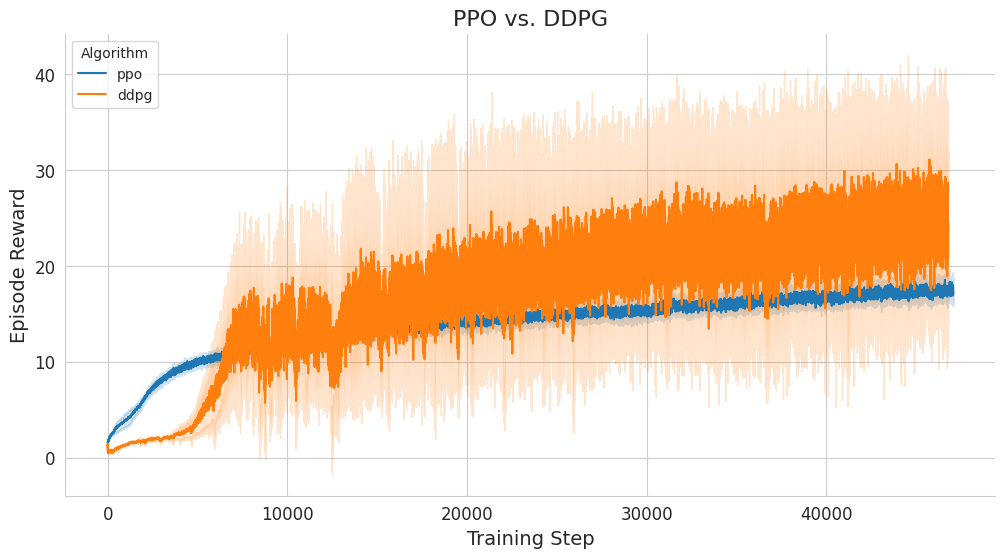

In [70]:
# Set the style of the plot to be more professional
sns.set_style(
    "whitegrid")  # This creates a grid background for better readability

# Create a larger figure size for better visibility
plt.figure(figsize=(12, 6))

# Plot the data
axes = sns.lineplot(x='step', y='episode_reward', hue='algo',
                    data=all_df, errorbar='sd')

# Set the labels and titles
axes.set_xlabel('Training Step', fontsize=14)  # Set x-axis label
axes.set_ylabel('Episode Reward', fontsize=14)  # Set y-axis label
axes.set_title('PPO vs. DDPG', fontsize=16)  # Set plot title

# Improve the legend
axes.legend(title='Algorithm', loc='upper left',
            fontsize='medium')  # Customize the legend

# Fine-tuning for professional appearance
axes.tick_params(labelsize=12)  # Adjust the size of the ticks
sns.despine()  # Remove the top and right spines

# Optional: Set specific limits for x and y axes, if needed
# axes.set_xlim([xmin, xmax])
# axes.set_ylim([ymin, ymax])

# Show the plot
plt.show()

In [55]:
# convert timestamp to datetime
all_df['timestamp_dt'] = pd.to_datetime(all_df['timestamp'])
all_df['timestamp_dt'].dtype


dtype('<M8[ns]')

In [56]:
# We need to align the plots by duration, otherwise the plots will be misaligned
# We can do this by finding the minimum timestamp for each algo and subtracting it from all timestamps

# this needs to be done for each algo and seed
for algo, group in all_df.groupby(['algo', 'seed']):
  min_timestamp = group['timestamp_dt'].min()
  all_df.loc[(all_df['algo'] == algo[0]) & (all_df['seed'] == algo[1]),
  'timestamp_adjusted'] = group['timestamp_dt'] - min_timestamp

In [57]:
# Now replace the datetimes in timestamp adjusted with td.seconds of that datetime
all_df['timestamp_adjusted'] = all_df['timestamp_adjusted'].apply(
    lambda x: x.seconds)

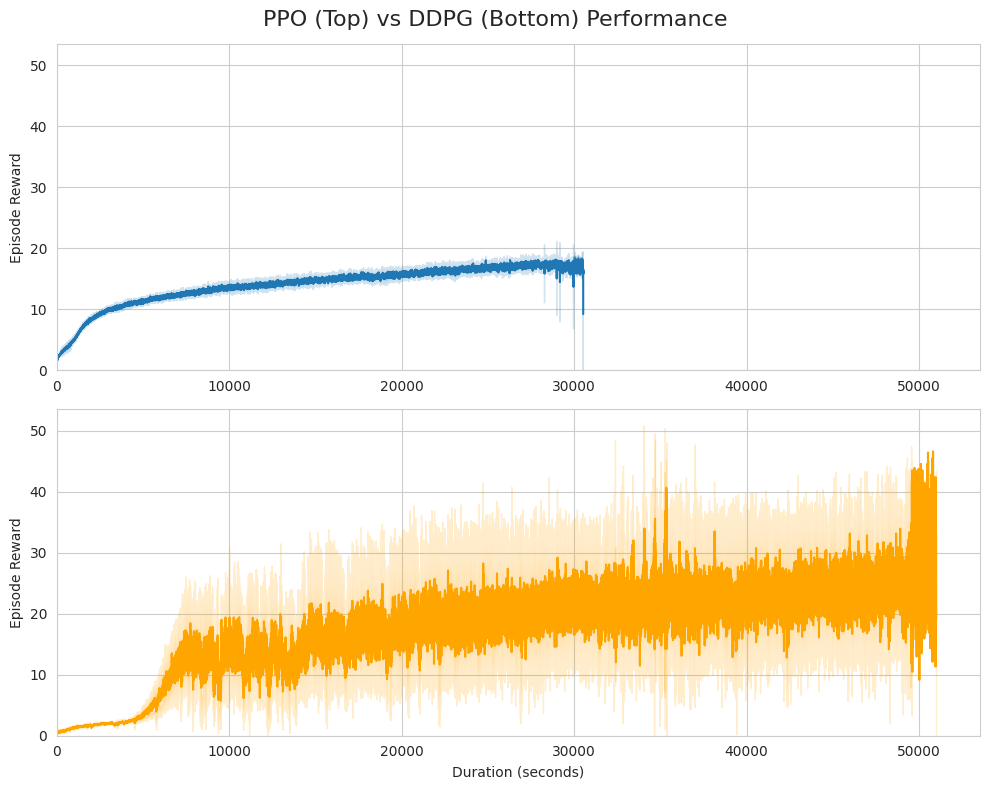

In [68]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Set a common title for the entire figure
fig.suptitle('PPO (Top) vs DDPG (Bottom) Performance', fontsize=16)

# Plot for 'ppo' on the first subplot
sns.lineplot(ax=ax1, x='timestamp_adjusted', y='episode_reward',
             data=all_df[all_df['algo'] == 'ppo'], errorbar='sd')
ax1.set_ylabel('Episode Reward')  # Only y-axis label for the first subplot

# remove the x-axis label for the first subplot
ax1.set_xlabel('')

# Plot for 'ddpg' on the second subplot
sns.lineplot(ax=ax2, x='timestamp_adjusted', y='episode_reward',
             data=all_df[all_df['algo'] == 'ddpg'], errorbar='sd',
             color='orange')
ax2.set_ylabel('Episode Reward')  # Only y-axis label for the second subplot
ax2.set_xlabel('Duration (seconds)')  # Only x-axis label for the second subplot

# Adjust the y-axis limits if necessary
ylim = max(ax1.get_ylim()[1], ax2.get_ylim()[1])
ax1.set_ylim(0, ylim)
ax2.set_ylim(0, ylim)

# Adjust the x-axis limits to match if necessary
max_x = max(ax1.get_xlim()[1], ax2.get_xlim()[1])
ax1.set_xlim(0, max_x)
ax2.set_xlim(0, max_x)

# Adjust layout for the title
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.tight_layout()
# Show the plot
plt.show()

### Determining the score thresholds for difficulties

In [13]:
mean_reward = all_df['episode_reward'].mean()
std_reward = all_df['episode_reward'].std()

# Using the CDF of a standard normal distribution to find the value at one standard deviation below the mean
novice_upper_bound = scipy.stats.norm.ppf(0.1587, loc=mean_reward,
                                          scale=std_reward)  # 0.1587 is the CDF value for -1 std dev in a standard normal distribution

# Intermediate bounds are simply one standard deviation below and above the mean
intermediate_lower_bound = mean_reward - std_reward
intermediate_upper_bound = mean_reward + std_reward

# Using the CDF of a standard normal distribution to find the value at one standard deviation above the mean

expert_lower_bound = scipy.stats.norm.ppf(0.8413, loc=mean_reward,
                                          scale=std_reward)  # 0.8413 is the CDF value for +1 std dev in a standard normal distribution

novice_score_bounds = (-np.inf, novice_upper_bound)
intermediate_score_bounds = (intermediate_lower_bound, intermediate_upper_bound)
expert_score_bounds = (expert_lower_bound, np.inf)

print(f'Novice Score Bounds: {novice_score_bounds}')
print(f'Intermediate Score Bounds: {intermediate_score_bounds}')
print(f'Expert Score Bounds: {expert_score_bounds}')


Novice Score Bounds: (-inf, 8.597322696508375)
Intermediate Score Bounds: (8.59604873671572, 22.375559821675346)
Expert Score Bounds: (22.37428586188269, inf)


In [14]:
levels_df = pd.DataFrame()

for algo in algo_to_exp_dict.keys():
  policies_path = os.path.join(experiment_base_dir, algo,
                               algo_to_exp_dict[algo],
                               f'**/policies/*_steps.zip')
  policies_paths = glob.glob(policies_path, recursive=True)

  policy_path_df = pd.DataFrame(policies_paths, columns=['path'])
  policy_path_df['step'] = policy_path_df['path'].str.extract(
      r'(\d+)_steps.zip', expand=False).astype(np.int32)
  policy_path_df['step'] = policy_path_df['step'] // 4096
  policy_path_df = policy_path_df.sort_values(by='step')
  policy_path_df['algo'] = algo
  policy_path_df['experiment'] = policy_path_df['path'].str.split('/').str[-4]
  policy_path_df['seed'] = \
    policy_path_df['path'].str.split('/').str[-3].str.split('_').str[-5].astype(
        np.int32)

  # Now we can simply inner join with the all_df dataframe to get the score at each step
  policy_path_df = policy_path_df.merge(
      all_df[['step', 'episode_reward', 'seed', 'algo', 'timestamp']],
      on=['step', 'seed', 'algo'], how='inner')

  # ADd a 'level' column to the policy_path_df
  policy_path_df['level'] = 'expert'

  # now label the policies as novice, intermediate, or expert
  policy_path_df.loc[
    policy_path_df['episode_reward'].between(
        *novice_score_bounds), 'level'] = 'novice'
  policy_path_df.loc[
    policy_path_df['episode_reward'].between(*intermediate_score_bounds),
    'level'] = 'intermediate'
  policy_path_df.loc[
    policy_path_df['episode_reward'].between(
        *expert_score_bounds), 'level'] = 'expert'
  levels_df = pd.concat([levels_df, policy_path_df])



In [15]:
TOP_K = 2

# This should give us the TOP_K policies for each algo and level
top_k_policies_df = (levels_df.groupby(['algo', 'level'])
                     .apply(lambda x: x.nlargest(TOP_K, 'episode_reward'))
                     .reset_index(drop=True))
top_k_policies_df

,path,step,algo,experiment,seed,episode_reward,timestamp,level
0,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,33356,ddpg,0002,65,43.004826,2023-11-10 08:21:16.541790976,expert
1,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,43412,ddpg,0002,65,42.930813,2023-11-10 11:25:06.525917696,expert
2,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,30658,ddpg,0002,98,22.332285,2023-11-09 22:49:01.146192640,intermediate
3,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,39488,ddpg,0002,23,22.303179,2023-11-10 01:32:12.237486080,intermediate
4,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,12263,ddpg,0002,98,8.559221,2023-11-09 17:27:03.273286912,novice
5,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,9074,ddpg,0002,82,8.485527,2023-11-09 02:41:47.529382400,novice
6,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,41696,ppo,0014,65,18.864553,2023-11-09 17:56:04.759102720,intermediate
7,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,44622,ppo,0014,82,18.494246,2023-11-09 09:59:19.723512832,intermediate
8,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,3658,ppo,0014,82,8.520645,2023-11-09 03:05:28.873665024,novice
9,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,3414,ppo,0014,82,8.493874,2023-11-09 03:03:01.919748608,novice


In [19]:
SKILL_LEVEL_TO_POLICY_STEP = collections.defaultdict(list)
for algo in algo_to_exp_dict.keys():
  for level in ('novice', 'intermediate', 'expert'):
    level_paths = top_k_policies_df[top_k_policies_df['level'] == level][
      'path'].values
    SKILL_LEVEL_TO_POLICY_STEP[level].extend(level_paths)

# Now merge the various difficulty level policies into a dictionary with keys for each level
print(SKILL_LEVEL_TO_POLICY_STEP)

defaultdict(<class 'list'>, {'novice': ['/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/0002/quadruped_locomotion_int_eval_freq_1000000_int_save_freq_1000000_parallel_cores_170_seed_98_total_env_steps_200000000/policies/rl_policy_50231250_steps.zip', '/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/0002/quadruped_locomotion_int_eval_freq_1000000_int_save_freq_1000000_parallel_cores_170_seed_82_total_env_steps_200000000/policies/rl_policy_37171125_steps.zip', '/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0014/quadruped_locomotion_int_save_freq_1000000_parallel_cores_170_seed_82_total_env_steps_200000000/policies/rl_policy_14985500_steps.zip', '/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/0014/quadruped_locomotion_int_save_freq_1000000_parallel_cores_170_seed_82_total_env_steps_200000000/policies/rl_policy_13986750_steps.zip', '/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotio

### Computing Window Size

In [21]:
EVAL_POINTS_PER_WINDOW = 5
med_step_diffs = []
for algo in algo_to_exp_dict.keys():
  algo_df = all_df[all_df['algo'] == algo]
  algo_grouped = algo_df.groupby('seed')
  for seed, group in algo_grouped:
    mean_step_diff = group['step'].diff().mean()
    median_step_diff = group['step'].diff().median()
    window_size = int(EVAL_POINTS_PER_WINDOW * median_step_diff)
    print(f'Seed: {seed}')
    print(f'\tMean step difference: {mean_step_diff}')
    print(f'\tMedian step difference: {median_step_diff}')
    print(f'\tWindow size: {window_size}')
    med_step_diffs.append(median_step_diff)

Seed: 14
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 37
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 65
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 82
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 98
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 14
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 23
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 65
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 82
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5
Seed: 98
	Mean step difference: 1.0
	Median step difference: 1.0
	Window size: 5


In [22]:
window_size = int(EVAL_POINTS_PER_WINDOW * np.mean(med_step_diffs))
avg_step_diff = int(np.mean(med_step_diffs))
window_size, avg_step_diff

(5, 1)

### Computing Reliability Metrics

In [23]:
eval_points = list(
    range(np.ceil(window_size / 2).astype(int), max(all_df['step']),
          avg_step_diff))
eval_points


[3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,


In [24]:
all_training_metrics = collections.defaultdict(dict)

In [25]:
window_fn = stats.iqr

for algo in algo_to_exp_dict.keys():
  all_iqr_values = []
  number_valid_eval_points = []
  seeds_to_process = algo_to_seeds[algo]
  print(f'Processing algo: {algo}')
  algo_filtered_df = all_df[all_df['algo'] == algo]
  for seed in seeds_to_process:
    windows_to_evaluate = []
    print(f'\tProcessing seed: {seed}')
    seed_filtered_df = algo_filtered_df[algo_filtered_df['seed'] == seed].copy()
    seed_filtered_df['episode_reward_diff'] = seed_filtered_df[
      'episode_reward'].diff()
    seed_filtered_df = seed_filtered_df[['step', 'episode_reward_diff']]
    seed_filtered_df = seed_filtered_df.dropna()
    print('\t\tNumber of rows: ', len(seed_filtered_df))
    steps, episode_reward_diff = seed_filtered_df.to_numpy().T
    for eval_point in eval_points:
      low_end = np.ceil(eval_point - (window_size / 2))
      high_end = np.floor(eval_point + (window_size / 2))

      eval_points_above = steps >= low_end
      eval_points_below = steps <= high_end
      eval_points_in_window = np.logical_and(eval_points_above,
                                             eval_points_below)
      valid_eval_points = np.nonzero(eval_points_in_window)[0]

      if len(valid_eval_points) == 0:
        # print(f'\t\tNo valid eval points for eval point: {eval_point}')
        # print(f'Stopping since that means current seed is done')
        break

      number_valid_eval_points.append(len(valid_eval_points))
      windows_to_evaluate.append(valid_eval_points)
    iqr_values = [window_fn(episode_reward_diff[window]) for window in
                  windows_to_evaluate]
    all_iqr_values.extend(iqr_values)
    # print(f'\t\tOn average there were {np.mean(number_valid_eval_points)} valid eval points per window')
    # print(f'\t\tMean IQR: {mean_iqr} +/- {np.std(iqr_values)}')
    # print(f'\t\tMedian IQR: {median_iqr}')

  all_training_metrics[algo]['iqr'] = dict(
      mean=np.mean(all_iqr_values),
      std=np.std(all_iqr_values)
  )
  print(
      f'\tAll mean iqr values: {np.mean(all_iqr_values)} +/- {np.std(all_iqr_values)}')


Processing algo: ppo
	Processing seed: 37
		Number of rows:  47058
	Processing seed: 14
		Number of rows:  47058
	Processing seed: 82
		Number of rows:  47058
	Processing seed: 65
		Number of rows:  47058
	Processing seed: 98
		Number of rows:  47058
	All mean iqr values: 0.6377997142289932 +/- 0.43598518910051376
Processing algo: ddpg
	Processing seed: 14
		Number of rows:  46783
	Processing seed: 82
		Number of rows:  46783
	Processing seed: 23
		Number of rows:  46783
	Processing seed: 65
		Number of rows:  46783
	Processing seed: 98
		Number of rows:  46783
	All mean iqr values: 4.81024256816842 +/- 4.1493787808189575



##### Long-term risk across time
Long - term risk across time represents the propensity of the agent to crash after achieving a higher performance measure

In [26]:
def compute_drawdown(sequence):
  """Computes the drawdown for a sequence of numbers.

    The drawdown at time T is the decline from the highest peak occurring at or
    before time T. https://en.wikipedia.org/wiki/Drawdown_(economics).

    The drawdown is always non-negative. A larger (more positive) drawdown
    indicates a larger drop.

  Args:
    sequence: A numpy array.

  Returns:
    A numpy array of same length as the original sequence, containing the
      drawdown at each timestep.
  """
  peak_so_far = np.maximum.accumulate(sequence)
  return peak_so_far - sequence

In [27]:
alpha = 0.95

for algo in algo_to_exp_dict.keys():
  all_cvars = []
  all_drawdowns = []
  print(f'Processing algo: {algo}')
  algo_filtered_df = all_df[all_df['algo'] == algo]
  seeds_to_process = algo_to_seeds[algo]
  for seed in seeds_to_process:
    print(f'\tProcessing seed: {seed}')

    seed_filtered_df = algo_filtered_df[algo_filtered_df['seed'] == seed].copy()
    seed_filtered_df = seed_filtered_df.sort_values(by='step')
    # Compute the drawdowns
    episode_rewards = seed_filtered_df['episode_reward'].values
    drawdowns = compute_drawdown(episode_rewards)
    all_drawdowns.extend(drawdowns)

    # Get the bottom "alpha" percent of drawdowns (we use the 95th percentile to get the bottom 5% of drawdowns)
    top_alpha_percent = np.percentile(drawdowns, alpha * 100)

    # CVaR is the average of the bottom "alpha" percent of drawdowns
    # cvar = np.mean(drawdowns[drawdowns <= bottom_alpha_percent]) we actually need greater than
    cvar = np.mean(drawdowns[drawdowns >= top_alpha_percent])
    all_cvars.append(cvar)
    print(f'\t\tCVaR: {cvar}')

  #now show overall mean and std of all cvars
  print(f'\tAll CVaR values: {all_cvars}')
  print(f'\tAverage CVaR value: {np.mean(all_cvars)} +/- {np.std(all_cvars)}')
  all_training_metrics[algo]['long_term_risk'] = dict(
      mean=np.mean(all_cvars),
      std=np.std(all_cvars)
  )
  # now compute the cvar of all drawdowns together
  all_drawdowns = np.array(all_drawdowns)
  top_alpha_percent = np.percentile(all_drawdowns, alpha * 100)
  cvar = np.mean(all_drawdowns[all_drawdowns >= top_alpha_percent])
  print(f'\tAll CVaR values: {cvar}')

Processing algo: ppo
	Processing seed: 37
		CVaR: 3.0964439645808546
	Processing seed: 14
		CVaR: 3.279831063934858
	Processing seed: 82
		CVaR: 2.970079079922645
	Processing seed: 65
		CVaR: 3.1323824893450465
	Processing seed: 98
		CVaR: 3.179904925585097
	All CVaR values: [3.0964439645808546, 3.279831063934858, 2.970079079922645, 3.1323824893450465, 3.179904925585097]
	Average CVaR value: 3.1317283046737 +/- 0.10161820563186288
	All CVaR values: 3.139068625239783
Processing algo: ddpg
	Processing seed: 14
		CVaR: 23.376586037492142
	Processing seed: 82
		CVaR: 23.490687570880112
	Processing seed: 23
		CVaR: 13.52622285403757
	Processing seed: 65
		CVaR: 32.91440239856895
	Processing seed: 98
		CVaR: 18.823315254834473
	All CVaR values: [23.376586037492142, 23.490687570880112, 13.52622285403757, 32.91440239856895, 18.823315254834473]
	Average CVaR value: 22.42624282316265 +/- 6.391073910362745
	All CVaR values: 26.603876381049954


##### Short-term risk across time
Short - term risk across time represents how volatile the agent is from eval point to eval point

In [28]:
alpha = 0.05
for algo in algo_to_exp_dict.keys():
  all_cvars = []
  all_diffs = []
  print(f'Processing algo: {algo}')
  algo_filtered_df = all_df[all_df['algo'] == algo]
  seeds_to_process = algo_to_seeds[algo]
  for seed in seeds_to_process:
    print(f'\tProcessing seed: {seed}')

    seed_filtered_df = algo_filtered_df[algo_filtered_df['seed'] == seed].copy()
    seed_filtered_df = seed_filtered_df.sort_values(by='step')

    seed_filtered_df['episode_reward_diff'] = seed_filtered_df[
      'episode_reward'].diff()
    seed_filtered_df = seed_filtered_df.dropna()

    episode_reward_diffs = seed_filtered_df['episode_reward_diff'].values
    all_diffs.extend(episode_reward_diffs)
    bottom_alpha_percent = np.percentile(episode_reward_diffs, alpha * 100,
                                         interpolation='linear')

    # CVaR is the average of the bottom "alpha" percent of diffs
    # cvar = np.mean(drawdowns[drawdowns <= top_alpha_percent])
    cvar = np.mean(
        episode_reward_diffs[episode_reward_diffs <= bottom_alpha_percent])
    all_cvars.append(cvar)
    print(f'\t\tCVaR: {cvar}')

  # Finally, report the mean and standard deviation of ALL the CVaR values in \pm notation
  print(f'\tAll CVaR values: {all_cvars}')
  print(f'\tAverage CVaR value: {np.mean(all_cvars)} +/- {np.std(all_cvars)}')
  all_training_metrics[algo]['short_term_risk'] = dict(
      mean=np.mean(all_cvars),
      std=np.std(all_cvars)
  )

  # now compute the cvar of all diffs together
  all_diffs = np.array(all_diffs)
  bottom_alpha_percent = np.percentile(all_diffs, alpha * 100,
                                       interpolation='linear')
  cvar = np.mean(all_diffs[all_diffs <= bottom_alpha_percent])
  print(f'\tAll CVaR values: {cvar}')

Processing algo: ppo
	Processing seed: 37
		CVaR: -1.294468191903143
	Processing seed: 14
		CVaR: -1.289630339695857
	Processing seed: 82
		CVaR: -1.2481261069755376
	Processing seed: 65
		CVaR: -1.240186230253778
	Processing seed: 98
		CVaR: -1.2910992705056985
	All CVaR values: [-1.294468191903143, -1.289630339695857, -1.2481261069755376, -1.240186230253778, -1.2910992705056985]
	Average CVaR value: -1.272702027866803 +/- 0.023494872449187226
	All CVaR values: -1.2730935535276893
Processing algo: ddpg
	Processing seed: 14
		CVaR: -10.861037742174588
	Processing seed: 82
		CVaR: -10.078339777746772
	Processing seed: 23
		CVaR: -6.881709538871407
	Processing seed: 65
		CVaR: -15.550833056319473
	Processing seed: 98
		CVaR: -9.363676822363821
	All CVaR values: [-10.861037742174588, -10.078339777746772, -6.881709538871407, -15.550833056319473, -9.363676822363821]
	Average CVaR value: -10.547119387495211 +/- 2.83517954277511
	All CVaR values: -11.377651500570423



##### Risk across runs
Risk across runs tells use how poor the final performance of the worst runs are

In [29]:
# Get the final episode reward for each seed
final_episode_rewards = all_df.groupby(['algo', 'seed']).tail(1)
final_episode_rewards

,Unnamed: 0,step,episode_reward,timestamp,seed,experiment,algo
47058,47058,47058,16.477169,2023-11-09 18:50:01.579202304,65,14,ppo
47058,47058,47058,17.552755,2023-11-09 10:35:04.081460736,14,14,ppo
47058,47058,47058,16.949339,2023-11-09 10:19:24.764899072,37,14,ppo
47058,47058,47058,17.002029,2023-11-09 10:32:03.431944704,82,14,ppo
47058,47058,47058,17.533741,2023-11-09 18:53:16.939280640,98,14,ppo
46783,46783,46783,36.381668,2023-11-10 12:27:54.742780672,65,2,ddpg
46783,46783,46783,25.597178,2023-11-10 03:41:58.244551424,98,2,ddpg
46783,46783,46783,17.298191,2023-11-10 03:36:44.945762304,23,2,ddpg
46783,46783,46783,21.929251,2023-11-09 13:53:59.170829312,82,2,ddpg
46783,46783,46783,19.661289,2023-11-09 13:51:44.168776960,14,2,ddpg


In [30]:
# Compute the CVaR of final episode rewards for each algo
alpha = 0.05
for algo in algo_to_exp_dict.keys():
  algo_final_episode_rewards = final_episode_rewards[
    final_episode_rewards['algo'] == algo]
  top_alpha_percent = np.percentile(
      algo_final_episode_rewards['episode_reward'].values, alpha * 100,
      interpolation='linear')
  cvar = np.mean(algo_final_episode_rewards['episode_reward'].values[
                   algo_final_episode_rewards[
                     'episode_reward'].values <= top_alpha_percent])
  print(f'Algo: {algo}, CVaR: {cvar}')
  all_training_metrics[algo]['risk_across_runs'] = cvar,


Algo: ppo, CVaR: 16.477169036865234
Algo: ddpg, CVaR: 17.29819107055664



#### Dispersion across runs


In [33]:
def lowpass_filter(curve, lowpass_thresh):
  filt_b, filt_a = scipy.signal.butter(8, lowpass_thresh)

  def butter_filter_fn(c):
    padlen = min(len(c) - 1, 3 * max(len(filt_a), len(filt_b)))
    return scipy.signal.filtfilt(filt_b, filt_a, curve, padlen=padlen)

  processed_curve = butter_filter_fn(curve)
  return processed_curve


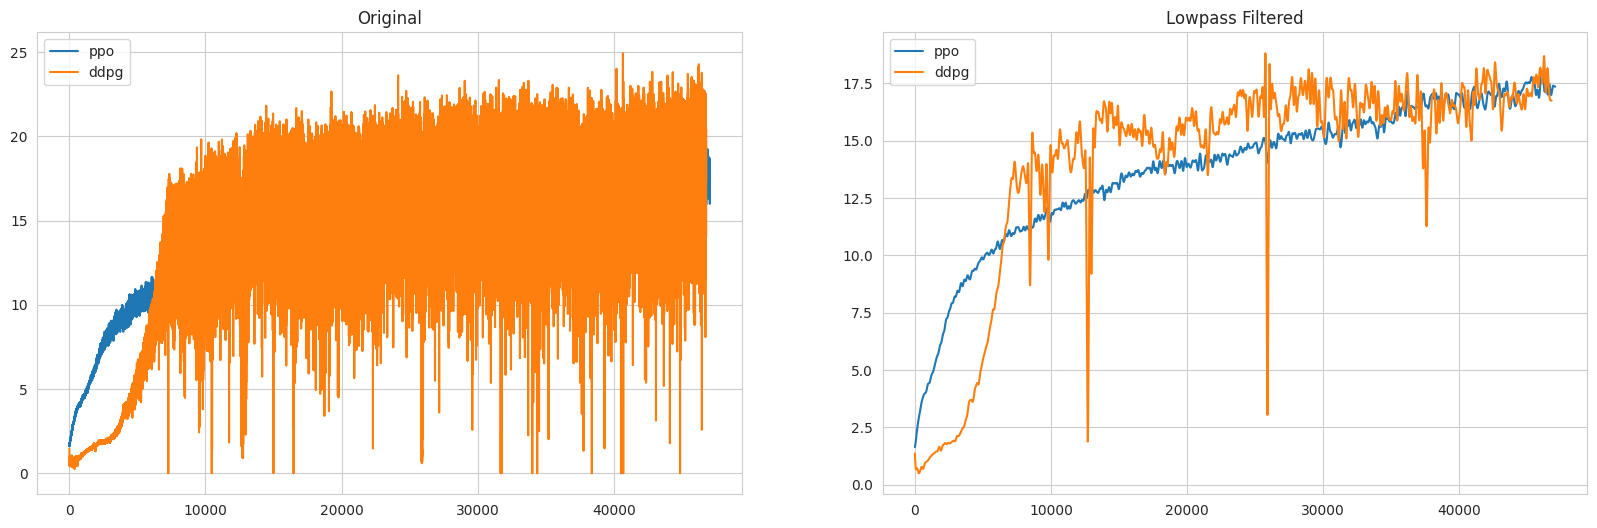

In [44]:
# Plot the first curve before and after lowpass filtering
# curve = ep_rew_clean[ep_rew_clean['seed'] == '37']['value'].values
# lowpass_curve = lowpass_filter(curve, lowpass_thresh=0.01)

ppo_curve = all_df[(all_df['algo'] == 'ppo') & (all_df['seed'] == 37)][
  'episode_reward'].values

ddpg_curve = all_df[(all_df['algo'] == 'ddpg') & (all_df['seed'] == 23)][
  'episode_reward'].values

low_pass_ppo_curve = lowpass_filter(ppo_curve, lowpass_thresh=0.01)
low_pass_ddpg_curve = lowpass_filter(ddpg_curve, lowpass_thresh=0.01)

# plot both curves with the original on the left, and lowpass on the right
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].plot(ppo_curve)
axes[0].plot(ddpg_curve)
axes[0].set_title('Original')
axes[1].plot(low_pass_ppo_curve)
axes[1].plot(low_pass_ddpg_curve)
axes[1].set_title('Lowpass Filtered')

#add a legend so it's easy to read
axes[0].legend(['ppo', 'ddpg'])
axes[1].legend(['ppo', 'ddpg'])


In [45]:
# For each algo, compute a new df with the lowpass filtered curves
lowpass_df = pd.DataFrame()
for algo in algo_to_exp_dict.keys():
  algo_df = all_df[all_df['algo'] == algo]
  for seed, group in algo_df.groupby('seed'):
    curve = group['episode_reward'].values
    lowpass_curve = lowpass_filter(curve, lowpass_thresh=0.01)
    group['lowpass_episode_reward'] = lowpass_curve
    lowpass_df = pd.concat([lowpass_df, group])

<Axes: xlabel='step', ylabel='lowpass_episode_reward'>

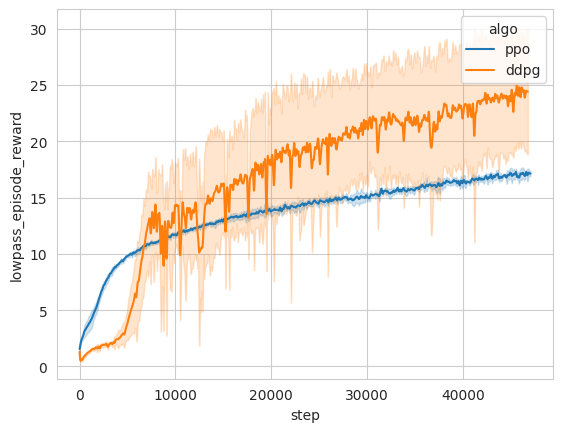

In [46]:
# plot both algorithms but group by the seeds to get mean and standard deviation
sns.lineplot(x='step', y='lowpass_episode_reward', hue='algo', data=lowpass_df,
             errorbar='sd')

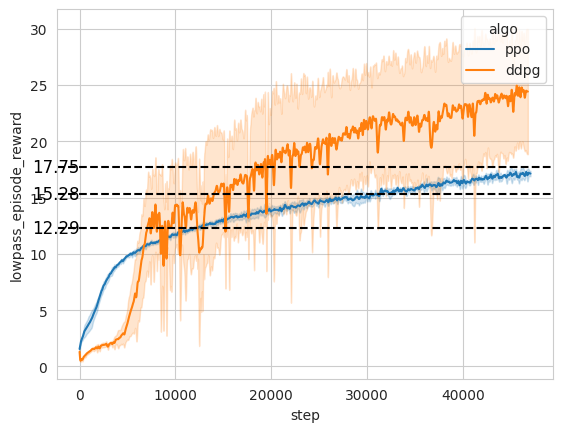

In [47]:
x = sns.lineplot(x='step', y='lowpass_episode_reward', hue='algo',
                 data=lowpass_df, errorbar='sd')
for loc in (novice_score, intermediate_score, expert_score):
  # draw horizontal lines and label the score thresholds
  x.axhline(loc, ls='--', color='black')
  x.text(0, loc, f'{loc:.2f}', ha='right', va='center', color='black',
         fontsize=12)


In [ ]:
for algo in algo_to_exp_dict.keys():
  algo_df = lowpass_df[lowpass_df['algo'] == algo]
  seeds_to_process = algo_to_seeds[algo]
  # These computations are for dispersion ACROSS runs. We simply need to group by step and then compute the IQR
  # of the episode rewards at each step

  # First examine the group to make sure we get the same number of values as the number of seeds
  for step, group in algo_df.groupby('step'):
    assert len(group) == len(
        seeds_to_process), f'Expected {len(seeds_to_process)} values but got {len(group)}'

  # Now compute the IQR of the episode rewards at each step
  iqr_values = algo_df.groupby('step')['lowpass_episode_reward'].apply(
      stats.iqr)
  mean_iqr = iqr_values.mean()
  print(f'Algo: {algo}, Mean IQR: {mean_iqr} +/- {np.std(iqr_values)}')
  all_training_metrics[algo]['dispersion_across_runs'] = dict(
      mean=mean_iqr,
      std=np.std(iqr_values)
  )

## System Metrics

In [ ]:
# Load all of the system metrics using glob and pandas csv

system_metric_dirs = []

for algo in algo_to_exp_dict.keys():
  experiment_path = os.path.join(experiment_base_dir, algo,
                                 algo_to_exp_dict[algo],
                                 f'**/train_emissions.csv')
  print(f'Experiment Path: {experiment_path}')

  system_metric_dirs.extend(glob.glob(experiment_path, recursive=True))

In [ ]:
len(system_metric_dirs)

In [ ]:
# Get the system metrics for each run
system_metrics_df = pd.DataFrame()

for metric_dir in system_metric_dirs:
  split_dir = metric_dir.split('/')
  exp_name = split_dir[-3]
  exp_name_split = exp_name.split('_')
  print(exp_name_split)
  seed = exp_name_split[-5]
  experiment = split_dir[-4]
  algo = split_dir[-5]

  print(f'Processing Experiment: {experiment}, Seed: {seed}, Algo: {algo}')

  df = pd.read_csv(metric_dir)
  df['seed'] = seed
  df['experiment'] = experiment
  df['algo'] = algo

  system_metrics_df = pd.concat([system_metrics_df, df])


In [ ]:
mean_duration = \
  system_metrics_df.groupby(['algo', 'seed']).tail(1).groupby('algo')[
    'duration'].mean()
std_duration = \
  system_metrics_df.groupby(['algo', 'seed']).tail(1).groupby('algo')[
    'duration'].std()

# display the mean +/- std nicely since they are in dataframes rn
for algo in algo_to_exp_dict.keys():
  # make into hours please
  mean_duration[algo] /= 3600
  std_duration[algo] /= 3600
  print(
      f'Algo: {algo}, Mean Duration: {mean_duration[algo]} +/- {std_duration[algo]}')
  all_training_metrics[algo]['duration'] = dict(
      mean=mean_duration[algo],
      std=std_duration[algo]
  )

In [ ]:
duration = system_metrics_df.groupby(['algo', 'seed']).tail(1).groupby('algo')[
  'duration'].mean()

In [ ]:
# Let's see the mean and standard deviation of the peak ram usage. we'll need to take the max of the process_ram column
mean_peak_ram = system_metrics_df.groupby(['algo', 'seed'])[
  'ram_process'].max().groupby('algo').mean()
std_peak_ram = system_metrics_df.groupby(['algo', 'seed'])[
  'ram_process'].max().groupby('algo').std()
# display the mean +/- std nicely since they are in dataframes rn
for algo in algo_to_exp_dict.keys():
  print(
      f'Algo: {algo}, Mean Peak RAM: {mean_peak_ram[algo]} +/- {std_peak_ram[algo]}')
  all_training_metrics[algo]['peak_ram'] = dict(
      mean=mean_peak_ram[algo],
      std=std_peak_ram[algo]
  )

In [ ]:
# Get the average ram usage for each algo
mean_ram = system_metrics_df.groupby('algo')['ram_process'].mean()
std_ram = system_metrics_df.groupby('algo')['ram_process'].std()
# display the mean +/- std nicely since they are in dataframes rn
for algo in algo_to_exp_dict.keys():
  print(f'Algo: {algo}, Mean RAM: {mean_ram[algo]} +/- {std_ram[algo]}')
  all_training_metrics[algo]['mean_ram'] = dict(
      mean=mean_ram[algo],
      std=std_ram[algo]
  )

## Computing the Training Sample Cost


In [ ]:
# Line up the step values for each algorithm with the system metrics
top_k_policies_df['true_step'] = top_k_policies_df['step'] * 4096

top_k_policies_df = top_k_policies_df.sort_values('timestamp')
system_metrics_df = system_metrics_df.sort_values('timestamp')
assert (top_k_policies_df[
          'true_step'] < 2e8).all(), 'Found a step value greater than 200 million'

top_k_policies_df

In [ ]:
system_metrics_df['timestamp'] = pd.to_datetime(system_metrics_df['timestamp'])
pd.merge_asof(top_k_policies_df, system_metrics_df, left_on='timestamp',
              right_on='timestamp', direction='nearest', )

---

# Inference Metrics


In [ ]:
import collections

all_inference_metrics = collections.defaultdict(dict)

In [ ]:
log_dirs = []
experiment_base_dir = os.path.join(base_dir, domain, 'debug' if debug else '',
                                   task)

for algo in algo_to_exp_dict.keys():
  seeds_to_process = algo_to_seeds[algo]
  experiment_path = os.path.join(experiment_base_dir, algo,
                                 algo_to_exp_dict[algo],
                                 f'**/inference_metric_results.json')
  print(f'Experiment Path: {experiment_path}')

  log_dirs.extend(glob.glob(experiment_path, recursive=True))

log_dirs = [log_dir for log_dir in log_dirs if
            any([f'seed_{seed}' in log_dir for seed in seeds_to_process])]
len(log_dirs)

In [ ]:
# Load each of the inference metric results into a dataframe
import collections

all_metrics_df = collections.defaultdict(pd.DataFrame)
for algo, exps in algo_to_exp_dict.items():
  algo_log_dirs = [log_dir for log_dir in log_dirs if algo in log_dir]

  for log_dir in algo_log_dirs:
    split_dir = os.path.normpath(log_dir).split(os.sep)
    exp_name = split_dir[-4]
    exp_name_split = exp_name.split('_')
    seed = exp_name_split[-5]
    experiment = split_dir[-5]

    print(f'Processing Experiment: {experiment}, Seed: {seed}, Algo: {algo}')
    assert algo == split_dir[
      -6], f'algo: {algo}, split_dir[-6]: {split_dir[-6]}'

    data = json.load(open(log_dir))

    for task, metrics in data.items():
      for metric, values in metrics.items():
        df = pd.DataFrame.from_dict(values, orient='columns', )
        df['task'] = task
        df['seed'] = seed
        df['experiment'] = experiment
        df['algo'] = algo
        df['metric'] = metric
        all_metrics_df[metric] = pd.concat([all_metrics_df[metric], df])

In [ ]:
system_metric_dirs = []
experiment_base_dir = os.path.join(base_dir, domain, 'debug' if debug else '',
                                   task)

for algo in algo_to_exp_dict.keys():
  experiment_path = os.path.join(experiment_base_dir, algo,
                                 algo_to_exp_dict[algo],
                                 f'**/inference_emissions.csv')
  print(f'Experiment Path: {experiment_path}')

  system_metric_dirs.extend(glob.glob(experiment_path, recursive=True))
len(system_metric_dirs)

In [ ]:
# Get the system metrics for each run
system_metrics_df = pd.DataFrame()

for metric_dir in system_metric_dirs:
  split_dir = metric_dir.split('/')
  exp_name = split_dir[-4]
  exp_name_split = exp_name.split('_')
  # print(exp_name_split)
  seed = exp_name_split[-5]
  experiment = split_dir[-5]
  algo = split_dir[-6]

  print(f'Processing Experiment: {experiment}, Seed: {seed}, Algo: {algo}')

  df = pd.read_csv(metric_dir)
  df['seed'] = seed
  df['experiment'] = experiment
  df['algo'] = algo

  system_metrics_df = pd.concat([system_metrics_df, df])

## System Metrics


In [ ]:
mean_duration = \
  system_metrics_df.groupby(['algo', 'seed']).tail(1).groupby('algo')[
    'duration'].mean()
std_duration = \
  system_metrics_df.groupby(['algo', 'seed']).tail(1).groupby('algo')[
    'duration'].std()

In [ ]:
for algo in algo_to_exp_dict.keys():
  print(
      f'Algo: {algo}, Mean Duration: {mean_duration[algo]} +/- {std_duration[algo]}')

  all_inference_metrics[algo]['duration'] = dict(
      mean=mean_duration[algo],
      std=std_duration[algo]
  )

In [ ]:
# Let's see the mean and standard deviation of the peak ram usage. we'll need to take the max of the process_ram column
mean_peak_ram = system_metrics_df.groupby(['algo', 'seed'])[
  'ram_process'].max().groupby('algo').mean()
std_peak_ram = system_metrics_df.groupby(['algo', 'seed'])[
  'ram_process'].max().groupby('algo').std()

In [ ]:
# display the mean +/- std nicely since they are in dataframes rn
for algo in algo_to_exp_dict.keys():
  print(
      f'Algo: {algo}, Mean Peak RAM: {mean_peak_ram[algo]} +/- {std_peak_ram[algo]}')
  all_inference_metrics[algo]['peak_ram'] = dict(
      mean=mean_peak_ram[algo],
      std=std_peak_ram[algo]
  )

# Get the average ram usage for each algo
mean_ram = system_metrics_df.groupby('algo')['ram_process'].mean()
std_ram = system_metrics_df.groupby('algo')['ram_process'].std()
# display the mean +/- std nicely since they are in dataframes rn
for algo in algo_to_exp_dict.keys():
  print(f'Algo: {algo}, Mean RAM: {mean_ram[algo]} +/- {std_ram[algo]}')
  all_inference_metrics[algo]['mean_ram'] = dict(
      mean=mean_ram[algo],
      std=std_ram[algo]
  )

In [ ]:
for metric, df in all_metrics_df.items():
  # Get the mean and standard deviation of the metric for each algo
  for algo, group in df.groupby('algo'):
    mean = group['values'].mean()
    std = group['values'].std()
    # use tabs to make it easier to read
    print(f'Algo: {algo}\tMetric: {metric}\tMean: {mean}\tStd: {std}')
    all_inference_metrics[algo][metric] = dict(
        mean=mean,
        std=std
    )
  print('-' * 50)  # A separator for easier reading

## Reliability Metrics

#### Dispersion across rollouts


In [ ]:
# Simply compute the IQR of the rollouts for each algo
for algo, group in all_metrics_df['rollout_returns'].groupby('algo'):
  iqr = scipy.stats.iqr(group['values'].values)
  #use tabs to make it easier to read
  print(f'Algo: {algo}\tIQR: {iqr}')
  all_inference_metrics[algo]['dispersion_across_rollouts'] = iqr



#### Risk across rollouts

In [ ]:
# Simply compute the CVaR of the rollouts for each algo
for algo, group in all_metrics_df['rollout_returns'].groupby('algo'):
  # Get the bottom "alpha" percent of rollouts (we use the 5th percentile to get the bottom 5% of rollouts)
  bottom_alpha_percent = np.percentile(group['values'].values, 5)
  # CVaR is the average of the bottom "alpha" percent of rollouts
  cvar = np.mean(
      group['values'].values[group['values'].values <= bottom_alpha_percent])
  #use tabs to make it easier to read
  print(f'Algo: {algo}\tCVaR: {cvar}')
  all_inference_metrics[algo]['risk_across_rollouts'] = cvar


#### Returns 

In [ ]:
# Simply compute the average return for each algo
for algo, group in all_metrics_df['rollout_returns'].groupby('algo'):
  mean = group['values'].mean()
  std = group['values'].std()
  #use tabs to make it easier to read
  print(f'Algo: {algo}\tMean: {mean}\tStd: {std}')
  all_inference_metrics[algo]['rollout_returns'] = dict(
      mean=mean,
      std=std
  )

# Display all metrics nicely

In [ ]:
for algo, metrics in all_training_metrics.items():
  print(f'Algo: {algo}')
  for metric, values in metrics.items():
    if isinstance(values, dict):
      mean = values['mean']
      std = values['std']
      print(f'\tMetric: {metric}\tMean: {mean}\tStd: {std}')
    else:
      print(f'\tMetric: {metric}\tValue: {values}')
  print('-' * 50)  # A separator for easier reading

In [ ]:
# print out all the inference metrics nicely with mean +/- std if they have that
for algo, metrics in all_inference_metrics.items():
  print(f'Algo: {algo}')
  for metric, values in metrics.items():
    if isinstance(values, dict):
      mean = values['mean']
      std = values['std']
      print(f'\tMetric: {metric}\tMean: {mean}\tStd: {std}')
    else:
      print(f'\tMetric: {metric}\tValue: {values}')
  print('-' * 50)  # A separator for easier reading

In [ ]:
# Combine all metrics and print them out nicely
all_metrics = dict()
for algo, metrics in all_training_metrics.items():
  all_metrics[f'training/{algo}'] = metrics

for algo, metrics in all_inference_metrics.items():
  all_metrics[f'inference/{algo}'] = metrics



In [ ]:
for metric, values in all_metrics.items():
  print(f'Metric: {metric}')
  for metric, values in metrics.items():
    if isinstance(values, dict):
      mean = values['mean']
      std = values['std']
      print(f'\tMetric: {metric}\tMean: {mean}\tStd: {std}')
    else:
      print(f'\tMetric: {metric}\tValue: {values}')
  print('-' * 50)  # A separator for easier reading

# Sandbox

In [ ]:

all_metrics_df['rollout_returns']['values'].describe()